In [1]:
source('../../source/basic.r')

source('../validataion.r')


Warning message:
“no function found corresponding to methods exports from ‘BSgenome’ for: ‘releaseName’”


In [2]:
suppressPackageStartupMessages({
    library(tidyverse)
    library(Signac)
    library(Seurat)
    library(GenomeInfoDb)
    library(EnsDb.Hsapiens.v86 )# hg38
    library(EnsDb.Hsapiens.v75) #hg19
    library(ggplot2)
    library(patchwork)
    library(data.table)
    library(Matrix)
    set.seed(1234)
})

In [3]:
mat = readRDS('data/original.seuratObject.rds')

In [4]:
mat

An object of class Seurat 
18404 features across 68458 samples within 1 assay 
Active assay: RNA (18404 features, 0 variable features)
 1 dimensional reduction calculated: umap

In [8]:
barcode.normal <- mat$disease[which(mat$disease=='normal')]

In [9]:
barcode.normal%>%length

[1] 38506

In [10]:
meta.data <- mat@meta.data

In [11]:
meta.data%>%pull(donor_id)%>%unique

[1] healthy_5  control_2  diabetic_4 diabetic_3 healthy_6  control_3 
 [7] diabetic_5 diabetic_2 healthy_4  diabetic_1 control_1  diabetic_7
[13] diabetic_6
13 Levels: control_1 control_2 control_3 diabetic_1 diabetic_2 ... healthy_6

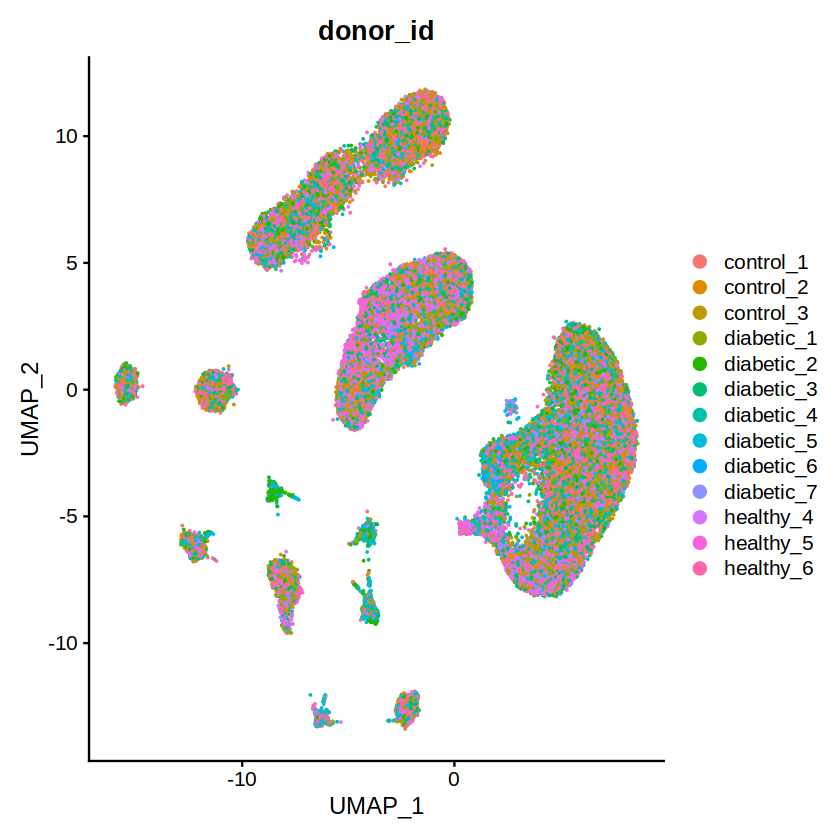

In [13]:
DimPlot(mat,group.by='donor_id')

# subset control6

In [14]:
mat.c6 <-mat[, mat$donor_id == "healthy_6"]

In [15]:
mat.c6

An object of class Seurat 
18404 features across 7795 samples within 1 assay 
Active assay: RNA (18404 features, 0 variable features)
 1 dimensional reduction calculated: umap

In [55]:
psize(12,5)

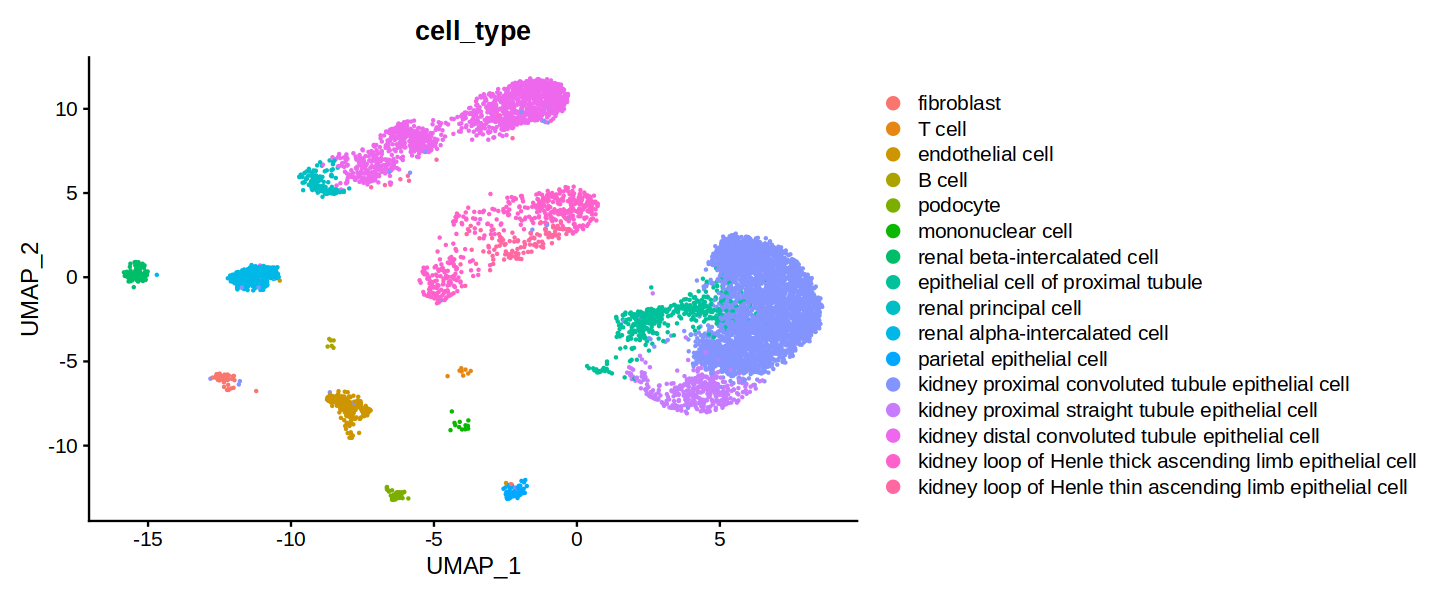

In [56]:
DimPlot(mat.c6,group.by='cell_type')

In [16]:
counts <- readMM("data/GSM5837793_Control6_fragments.tsv.gz.mtx") 


counts%>%dim

fread('data/GSM5837793_Control6_filtered_peak_bc_matrix.h5.barcode',header = FALSE)%>%
                    pull(V1)%>%length

[1] 1568814   10325

[1] 10325

In [17]:
colnames(counts) <- fread('data/GSM5837793_Control6_filtered_peak_bc_matrix.h5.barcode',header = FALSE)%>%
                    pull(V1)

rownames(counts) <-  fread('../../trans2cPeaks/cPeaks_hg38.bed')%>%mutate(name=paste0(V1,':',V2,'-',V3))%>%pull(name)


In [18]:
metadata <- mat.c6@meta.data

In [19]:
rownames(metadata) <- rownames(metadata)%>%gsub('-11','-1',.)

In [20]:
metadata%>%dim

[1] 7795   29

In [21]:
counts%>%dim

[1] 1568814   10325

In [22]:
# metadata <- read.csv(
#   file = "./data/atac_v1_seurat.object_10k_singlecell.csv",
#   header = TRUE,
#   row.names = 1
# )

chrom_assay <- CreateChromatinAssay(
  counts = counts,
  sep = c(":", "-"),
  genome = 'hg38',
  fragments = './data/GSM5837793_Control6_fragments.tsv.gz',
  min.cells = 80,
  min.features = 0
)


Warning message in CreateChromatinAssay(counts = counts, sep = c(":", "-"), genome = "hg38", :
"Overlapping ranges supplied. Ranges should be non-overlapping."
Computing hash



In [23]:
seurat.object.all <- CreateSeuratObject(
  counts = chrom_assay,
  assay = "peaks",
  meta.data = metadata
)

Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from peaks to peaks_"


In [24]:
seurat.object <- subset(seurat.object.all, cells = rownames(metadata))

In [25]:
seurat.object

An object of class Seurat 
201641 features across 7795 samples within 1 assay 
Active assay: peaks (201641 features, 0 variable features)

In [26]:
seurat.object <- RunTFIDF(seurat.object)
seurat.object <- FindTopFeatures(seurat.object, min.cutoff = 'q0')
seurat.object <- RunSVD(seurat.object)

Performing TF-IDF normalization

Running SVD

Scaling cell embeddings



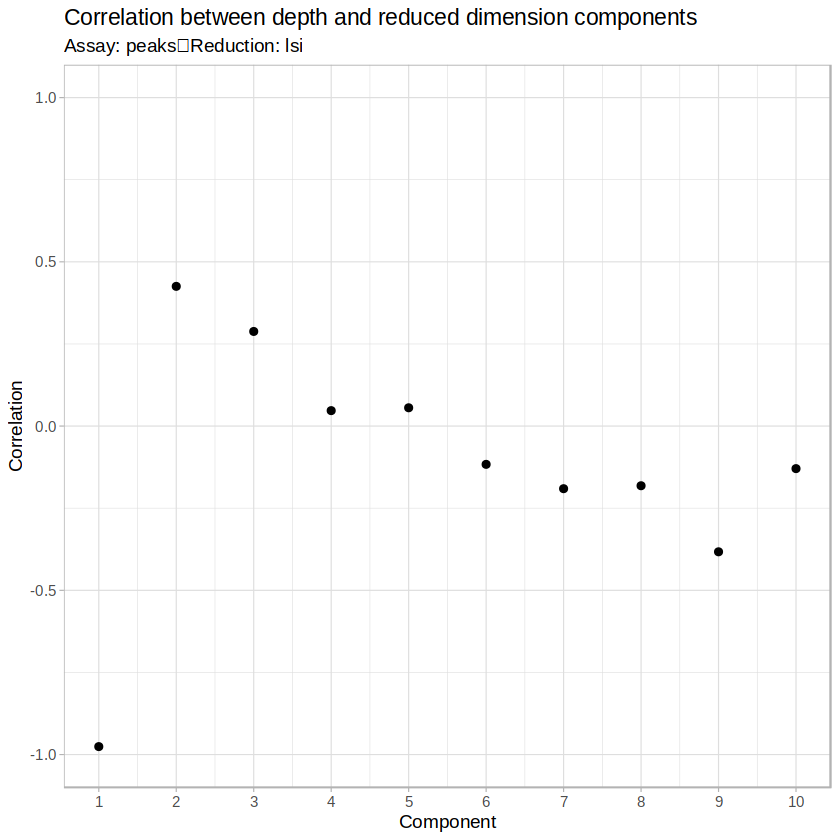

In [27]:
DepthCor(seurat.object)

In [ ]:
seurat.object <- RunUMAP(object = seurat.object, reduction = 'lsi', dims = 2:30)
seurat.object <- FindNeighbors(object = seurat.object, reduction = 'lsi', dims = 2:30)
seurat.object <- FindClusters(object = seurat.object, verbose = FALSE, algorithm = 3)
# p.umpa.cluster = DimPlot(object = seurat.object, label = TRUE) + NoLegend()

In [29]:
p.umpa.cluster = DimPlot(object = seurat.object, label = TRUE) + NoLegend()

In [30]:
psize()

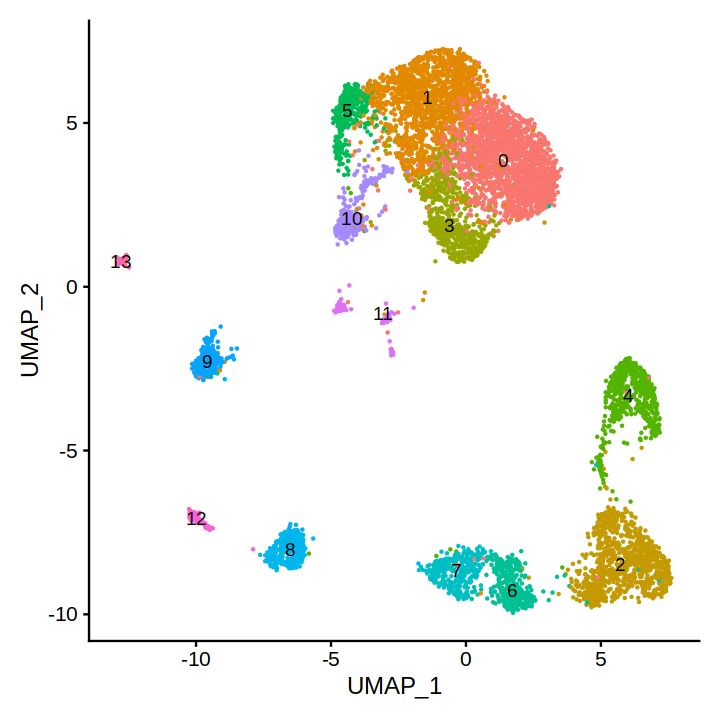

In [31]:
p.umpa.cluster

In [32]:

p.umpa.label = DimPlot(object = seurat.object,group.by='cell_type',label = TRUE) + NoLegend()

In [33]:
psize(10,10)

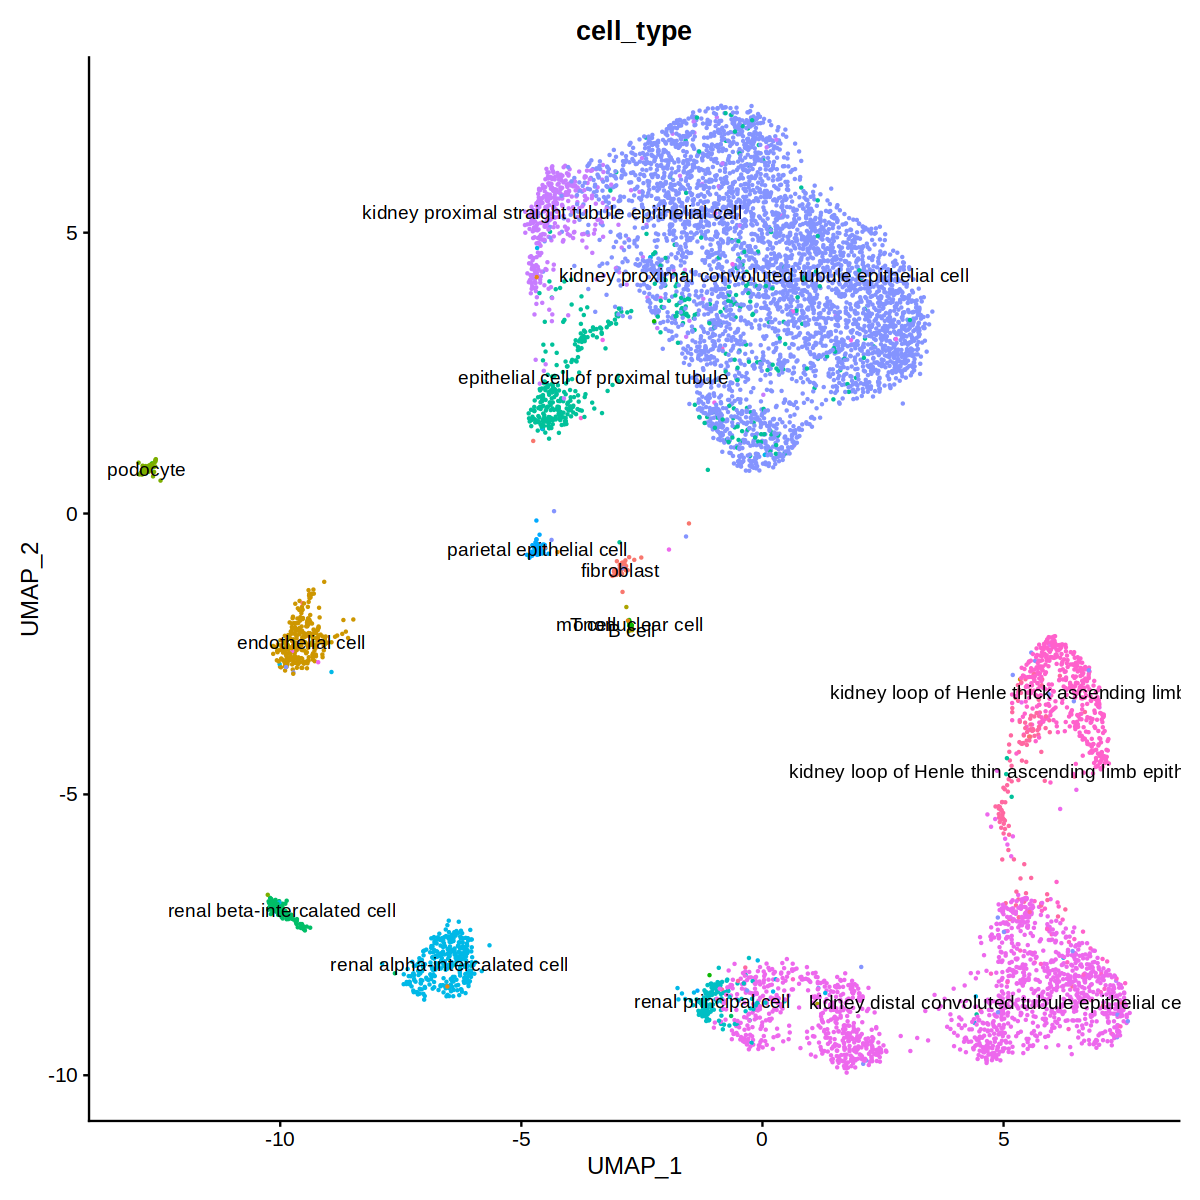

In [34]:
p.umpa.label

In [35]:

p.umpa.label2 = DimPlot(object = seurat.object,group.by='author_cell_type',label = TRUE) + NoLegend()

In [36]:
psize(10,10)

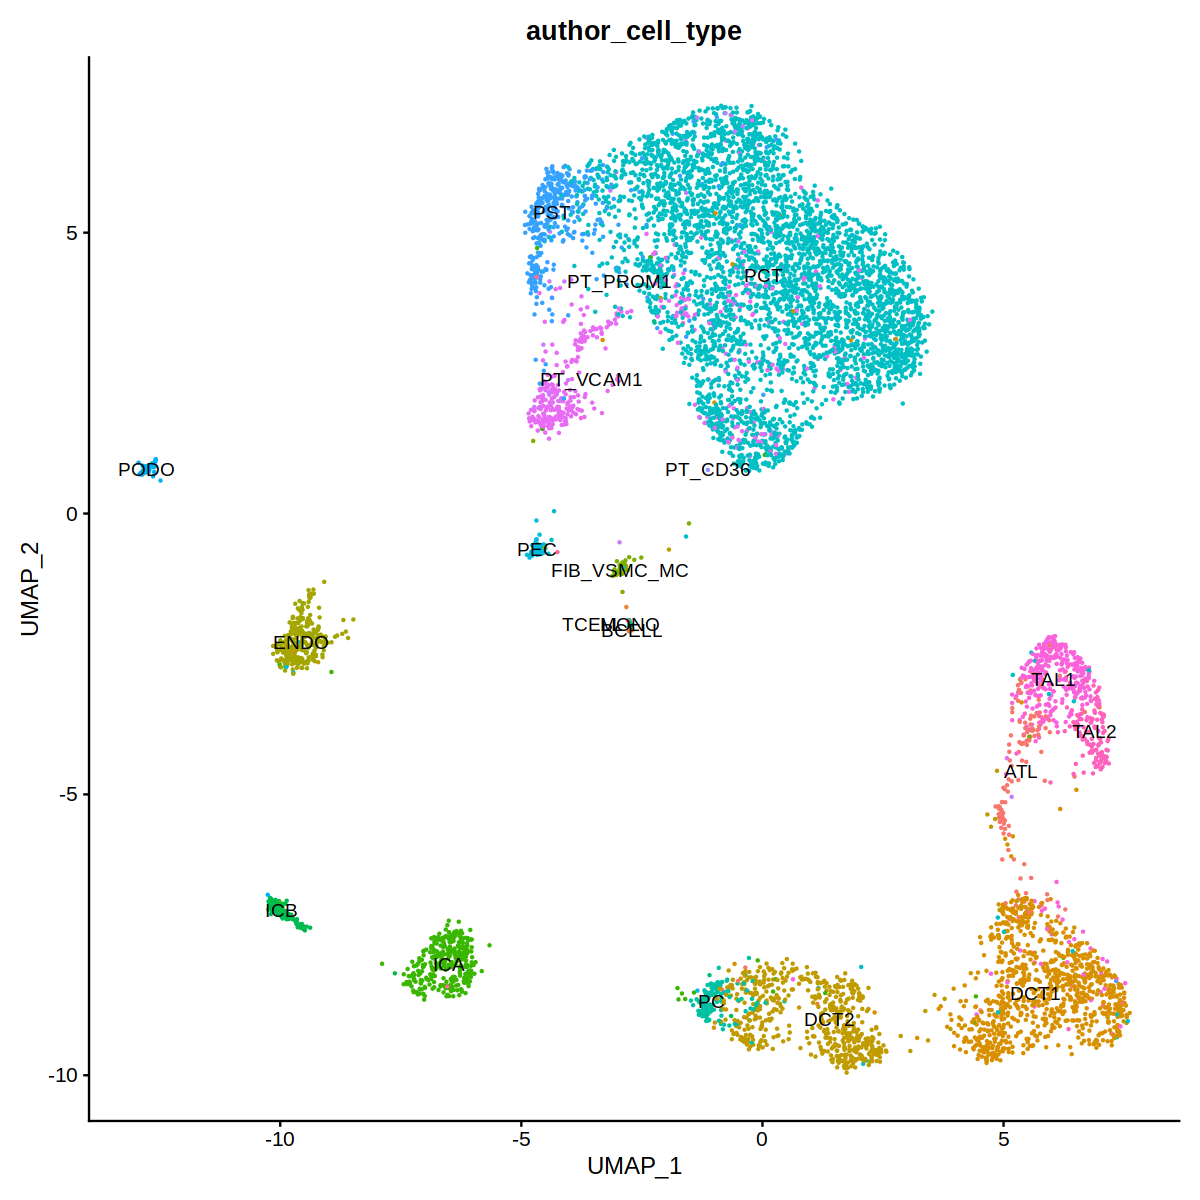

In [37]:
p.umpa.label2

In [46]:
tmp = seurat.object@meta.data%>%group_by(author_cell_type)%>%summarise(n=n())%>% dplyr::filter(n>10)%>%pull(author_cell_type)%>%as.character

pdf('plot/control6_all.pdf',height=7,width=6)
p.ump.cluster = DimPlot(object = seurat.object, cells = seurat.object@meta.data%>%dplyr::filter(author_cell_type%in%tmp)%>%rownames,label = TRUE) + NoLegend()
(p.ump.cluster+theme(aspect.ratio = 1)+ggtitle('Control'))%>%print
#ggsave(paste0('plot/all-control-clusters.pdf'),height = 6,width = 15)
p.ump.label = DimPlot(object = seurat.object,cells = seurat.object@meta.data%>%dplyr::filter(author_cell_type%in%tmp)%>%rownames,group.by='cell_type',label = TRUE) + NoLegend()
(p.ump.label+theme(aspect.ratio = 1)+ggtitle('Control'))%>%print
#ggsave(paste0('plot/all-control-umap1.pdf'),height = 10,width = 15)
p.ump.label2 = DimPlot(object = seurat.object,cells = seurat.object@meta.data%>%dplyr::filter(author_cell_type%in%tmp)%>%rownames,group.by='author_cell_type',label = TRUE) + NoLegend()
(p.ump.label2+theme(aspect.ratio = 1)+ggtitle('Control'))%>%print
#ggsave(paste0('plot/all-DN-control-umap2.pdf'),height = 10,width = 15)
dev.off()


png 
  2

In [ ]:
# tmp = seurat.object@meta.data%>%group_by(author_cell_type)%>%summarise(n=n())%>% dplyr::filter(n>10)%>%pull(author_cell_type)%>%as.character

# p.ump.cluster = DimPlot(object = seurat.object, cells = seurat.object@meta.data%>%dplyr::filter(author_cell_type%in%tmp)%>%rownames,label = TRUE)# + NoLegend()
# p.ump.cluster+theme(aspect.ratio = 1)
# ggsave(paste0('plot/all-control-clusters.pdf'),height = 10,width = 15)
# p.ump.label = DimPlot(object = seurat.object,cells = seurat.object@meta.data%>%dplyr::filter(author_cell_type%in%tmp)%>%rownames,group.by='cell_type',label = TRUE)# + NoLegend()
# p.ump.label+theme(aspect.ratio = 1)
# ggsave(paste0('plot/all-control-umap1.pdf'),height = 10,width = 15)
# p.ump.label2 = DimPlot(object = seurat.object,cells = seurat.object@meta.data%>%dplyr::filter(author_cell_type%in%tmp)%>%rownames,group.by='author_cell_type',label = TRUE) #+ NoLegend()
# p.ump.label2+theme(aspect.ratio = 1)
# ggsave(paste0('plot/all-DN-control-umap2.pdf'),height = 10,width = 15)
